
# Previsão de Produtividade (YIELD_KG_PER_HA)

Notebook simples para gerar um dataset sintético de safra e treinar **4 modelos de regressão**:
1) Regressão Linear  
2) Random Forest  
3) XGBoost Regressor  
4) Rede Neural (MLPRegressor)

**Objetivo**: prever `YIELD_KG_PER_HA` usando variáveis de plantio e médias de sensores simuladas.


In [8]:

# Imports principais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost é opcional. Se não tiver, o notebook segue sem ele.
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print("Aviso: xgboost não está disponível. Pulei este modelo. (Instale com: pip install xgboost)")

np.random.seed(42)


## 1) Geração do dataset sintético

In [9]:

# Aqui eu gero dados simulados de campos, plantios e médias de sensores.
# A saída é um CSV com ~1200 linhas contendo a produtividade (YIELD_KG_PER_HA).

from datetime import datetime, timedelta
import random

np.random.seed(42)
random.seed(42)

N = 1200  # número de registros

# Defino 3 culturas com produtividades base e faixas "boas" de clima/solo
crops = [
    {"CROP_ID": 1, "CROP_NAME": "Soja",  "baseline": 3500, "opt_temp": (22, 30), "opt_hum": (50, 70), "opt_ph": (6.0, 6.8)},
    {"CROP_ID": 2, "CROP_NAME": "Milho", "baseline": 6000, "opt_temp": (20, 28), "opt_hum": (45, 65), "opt_ph": (5.8, 7.0)},
    {"CROP_ID": 3, "CROP_NAME": "Trigo", "baseline": 3000, "opt_temp": (12, 22), "opt_hum": (40, 60), "opt_ph": (6.0, 7.0)},
]

def range_score(val, low, high, tol=0.15):
    # 1.0 dentro da faixa ótima, penaliza suavemente fora
    if low <= val <= high:
        return 1.0
    if val < low:
        d = (low - val) / (high - low + 1e-9)
    else:
        d = (val - high) / (high - low + 1e-9)
    return max(0.0, 1.0 - (d / tol))

start_date = datetime(2023, 1, 1)
def random_date():
    return start_date + timedelta(days=int(np.random.uniform(0, 730)))

# Campos com áreas diferentes
num_fields = 25
fields = [{"FIELD_ID": i+1, "AREA_HA": np.round(np.random.uniform(5, 80), 2)} for i in range(num_fields)]

records = []
for i in range(N):
    crop = random.choice(crops)
    field = random.choice(fields)
    field_id = field["FIELD_ID"]
    area_ha = field["AREA_HA"]
    planting_date = random_date()

    # Médias da "safra" (poderiam vir de sensores agregados)
    temp_avg = np.round(np.random.normal(24, 4), 2)
    hum_avg  = np.round(np.random.normal(55, 10), 1)
    ph_avg   = np.round(np.random.normal(6.3, 0.5), 2)
    rainfall_mm = np.round(np.random.normal(450, 120), 1)
    ndvi_mean   = np.clip(np.round(np.random.normal(0.65, 0.1), 3), 0, 1)

    # Densidade de sementes (por cultura)
    if crop["CROP_NAME"] == "Soja":
        seed_density = int(np.random.normal(300000, 40000))
    elif crop["CROP_NAME"] == "Milho":
        seed_density = int(np.random.normal(65000, 8000))
    else:
        seed_density = int(np.random.normal(180000, 25000))

    # Notas em relação às faixas "boas"
    s_temp = range_score(temp_avg, *crop["opt_temp"])
    s_hum  = range_score(hum_avg,  *crop["opt_hum"])
    s_ph   = range_score(ph_avg,   *crop["opt_ph"])
    s_rain = range_score(rainfall_mm, 400, 700, tol=0.25)  # água adequada genérica
    s_ndvi = range_score(ndvi_mean, 0.6, 0.8, tol=0.2)

    # Combino efeitos de forma simples e adiciono ruído
    agr_factor = (0.30*s_temp + 0.20*s_hum + 0.15*s_ph + 0.20*s_rain + 0.15*s_ndvi)
    agr_factor = np.clip(agr_factor, 0.0, 1.1)

    # Densidade de sementes com ótimo por cultura (efeito em parábola)
    if crop["CROP_NAME"] == "Soja":
        sd_opt, sd_tol = 300000, 120000
    elif crop["CROP_NAME"] == "Milho":
        sd_opt, sd_tol = 65000, 20000
    else:
        sd_opt, sd_tol = 180000, 60000
    sd_score = max(0.0, 1.0 - ((seed_density - sd_opt) / sd_tol)**2)

    # Produtividade final (kg/ha)
    noise = np.random.normal(0, 0.08)
    yield_kg_ha = crop["baseline"] * (0.65 + 0.35*agr_factor) * (0.75 + 0.25*sd_score) * (1 + noise)
    yield_kg_ha = float(np.round(max(0, yield_kg_ha), 2))

    records.append({
        "FIELD_ID": field_id,
        "AREA_HA": area_ha,
        "CROP_ID": crop["CROP_ID"],
        "CROP_NAME": crop["CROP_NAME"],
        "PLANTING_DATE": planting_date.date().isoformat(),
        "SEED_DENSITY_PER_HA": seed_density,
        "TEMP_AVG_C": temp_avg,
        "HUMIDITY_AVG_PCT": hum_avg,
        "PH_SOIL_AVG": ph_avg,
        "RAINFALL_TOTAL_MM": rainfall_mm,
        "NDVI_MEAN": ndvi_mean,
        "YIELD_KG_PER_HA": yield_kg_ha,
    })

df = pd.DataFrame(records)

# Salvo em data/ (pasta local do projeto)
import os
os.makedirs("data", exist_ok=True)
csv_path = "data/dataset_safra_simulada.csv"
df.to_csv(csv_path, index=False)
print("CSV gerado em:", csv_path)
df.head()


CSV gerado em: data/dataset_safra_simulada.csv


,FIELD_ID,AREA_HA,CROP_ID,CROP_NAME,PLANTING_DATE,SEED_DENSITY_PER_HA,TEMP_AVG_C,HUMIDITY_AVG_PCT,PH_SOIL_AVG,RAINFALL_TOTAL_MM,NDVI_MEAN,YIELD_KG_PER_HA
0,4,49.90,3,Trigo,2024-07-27,189392,24.27,40.8,6.03,463.3,0.535,2391.31
1,24,32.48,1,Soja,2024-05-14,290821,22.83,44.8,6.22,386.0,0.649,3304.39
2,8,69.96,2,Milho,2024-04-28,66370,24.84,35.4,5.64,473.6,0.724,5244.81
3,5,16.70,1,Soja,2023-10-11,254777,22.80,62.7,6.03,288.4,0.562,3003.02
4,4,49.90,3,Trigo,2024-08-08,172269,21.29,61.1,6.82,561.8,0.566,2851.16


## 2) Carregar o CSV e preparar os dados

In [10]:

import pandas as pd

df = pd.read_csv("data/dataset_safra_simulada.csv")
print(df.shape)
df.head()


(1200, 12)


,FIELD_ID,AREA_HA,CROP_ID,CROP_NAME,PLANTING_DATE,SEED_DENSITY_PER_HA,TEMP_AVG_C,HUMIDITY_AVG_PCT,PH_SOIL_AVG,RAINFALL_TOTAL_MM,NDVI_MEAN,YIELD_KG_PER_HA
0,4,49.90,3,Trigo,2024-07-27,189392,24.27,40.8,6.03,463.3,0.535,2391.31
1,24,32.48,1,Soja,2024-05-14,290821,22.83,44.8,6.22,386.0,0.649,3304.39
2,8,69.96,2,Milho,2024-04-28,66370,24.84,35.4,5.64,473.6,0.724,5244.81
3,5,16.70,1,Soja,2023-10-11,254777,22.80,62.7,6.03,288.4,0.562,3003.02
4,4,49.90,3,Trigo,2024-08-08,172269,21.29,61.1,6.82,561.8,0.566,2851.16


In [11]:

# Eu vou usar as variáveis numéricas e a cultura (one-hot).
# Evito usar FIELD_ID porque é um identificador e pode confundir o modelo.
df_model = df.copy()

X = df_model[[
    "AREA_HA",
    "SEED_DENSITY_PER_HA",
    "TEMP_AVG_C",
    "HUMIDITY_AVG_PCT",
    "PH_SOIL_AVG",
    "RAINFALL_TOTAL_MM",
    "NDVI_MEAN",
    "CROP_NAME"
]]
y = df_model["YIELD_KG_PER_HA"]

# One-hot para a cultura
X = pd.get_dummies(X, columns=["CROP_NAME"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape


((960, 9), (240, 9))

In [12]:
def avaliar_modelo(nome, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # raiz do MSE
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{nome}: R2={r2:.4f} | RMSE={rmse:.2f} | MAE={mae:.2f}")
    return {"modelo": nome, "R2": r2, "RMSE": rmse, "MAE": mae}

def plot_real_vs_previsto(y_true, y_pred, titulo):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    # linha de referência y=x
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims)
    plt.xlabel("Real")
    plt.ylabel("Previsto")
    plt.title(titulo)
    plt.show()


## 3) Modelo 1 — Regressão Linear

LinearRegression: R2=0.8958 | RMSE=413.36 | MAE=320.71


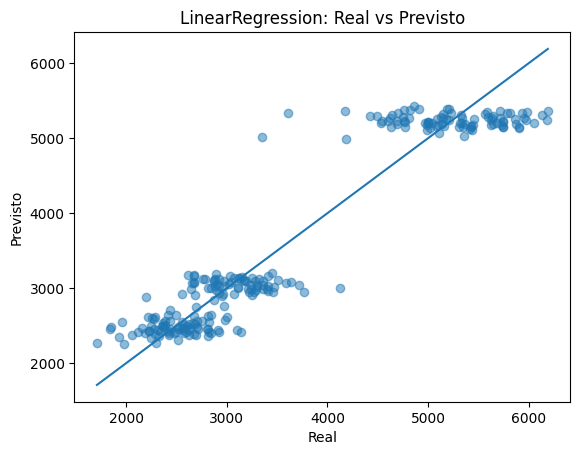

In [13]:

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

m_lr = avaliar_modelo("LinearRegression", y_test, pred_lr)
plot_real_vs_previsto(y_test, pred_lr, "LinearRegression: Real vs Previsto")


## 4) Modelo 2 — RandomForestRegressor

RandomForest: R2=0.9152 | RMSE=372.93 | MAE=277.69


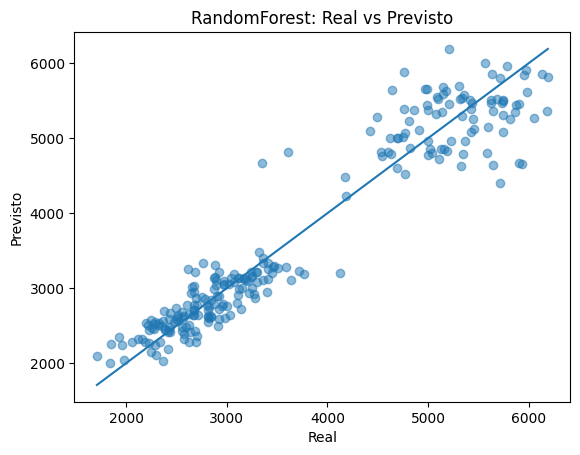

In [14]:

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

m_rf = avaliar_modelo("RandomForest", y_test, pred_rf)
plot_real_vs_previsto(y_test, pred_rf, "RandomForest: Real vs Previsto")


## 5) Modelo 3 — XGBoost Regressor

XGBoost: R2=0.9186 | RMSE=365.38 | MAE=275.30


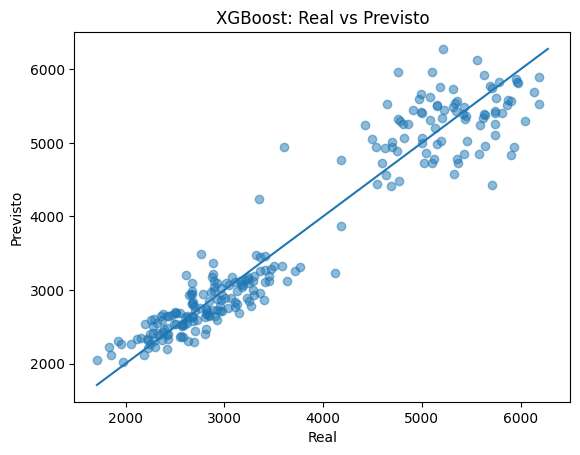

In [15]:

if HAS_XGB:
    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist"
    )
    xgb.fit(X_train, y_train)
    pred_xgb = xgb.predict(X_test)
    m_xgb = avaliar_modelo("XGBoost", y_test, pred_xgb)
    plot_real_vs_previsto(y_test, pred_xgb, "XGBoost: Real vs Previsto")
else:
    m_xgb = None
    print("XGBoost não rodou aqui. Se quiser usar, instale xgboost e execute novamente.")


## 6) Modelo 4 — Rede Neural (MLPRegressor)

MLPRegressor: R2=0.8548 | RMSE=487.93 | MAE=384.14


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


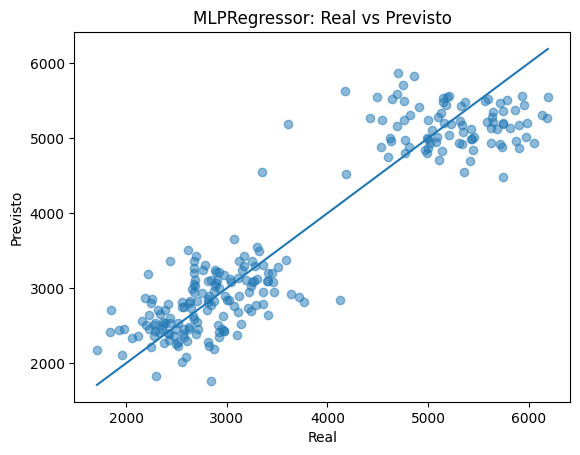

In [16]:

# Rede neural simples. Não esqueça que ela pode precisar de mais épocas e padronização.
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False por causa de one-hot
    ("mlp", MLPRegressor(hidden_layer_sizes=(64,32), activation="relu", random_state=42, max_iter=500))
])

mlp.fit(X_train, y_train)
pred_mlp = mlp.predict(X_test)

m_mlp = avaliar_modelo("MLPRegressor", y_test, pred_mlp)
plot_real_vs_previsto(y_test, pred_mlp, "MLPRegressor: Real vs Previsto")


## 7) Comparação final

In [17]:

resultados = [m_lr, m_rf, m_mlp] + ([m_xgb] if m_xgb is not None else [])
resultados = [m for m in resultados if m is not None]
df_res = pd.DataFrame(resultados).sort_values(by="R2", ascending=False).reset_index(drop=True)
df_res


,modelo,R2,RMSE,MAE
0,XGBoost,0.918596,365.380061,275.299804
1,RandomForest,0.915195,372.932972,277.686137
2,LinearRegression,0.895815,413.355905,320.711964
3,MLPRegressor,0.854831,487.930806,384.144520
